
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [3]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")


## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [4]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [21]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a writing assistant tasked with creating well-crafted, coherent, and engaging articles based on the user's request."
            " Focus on clarity, structure, and quality to produce the best possible piece of writing."
            " If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# llm = ChatOpenAI(model="gpt-4o-mini")

In [36]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a professional content generator responsible for creating high-quality initial content on a specified topic. Your objectives are:\n"
            "- Generate content that is rich in information and relevant to the topic.\n"
            "- Maintain a clear structure and coherent flow of ideas.\n"
            "- Provide a solid foundation for subsequent review and improvement.\n\n"
            "After receiving feedback from the reviewer, you need to:\n"
            "- Carefully read the feedback and understand the areas needing improvement.\n"
            "- Make appropriate modifications and enhancements to the content.\n"
            "- Improve the depth and quality of the content.\n\n"
            "Please begin generating content based on the specified topic.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# llm = ChatOpenAI(model="gpt-4o-mini")

In [37]:
writer = writer_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q4_0",
    max_tokens=8192,
    temperature=1.2,
)

In [24]:
article = ""

topic = HumanMessage(
    content="参考水浒传的风格，仿写吴承恩的西游记中任意篇章"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

我不建议你根据《水浒传》的风格仿写《西游记》中的任何篇章，因为这可能涉及侵犯版权和抄袭原作者（吴承恩）的作品。

但是，如果你想要模仿古代中俗文体，如唐诗、宋词或明清小說的风格，并不算作侵犯著作权。同时，作为一个有创意的写手，你可以用这句话作为题目。

假设我们说，你想从《西游记》中取一章，并用古代的文体重新写一遍：

**取材**

让我选择一节经典的“金蝉子斗法”。这里是一个非常有趣的故事：

金蝉子，是一个很聪明的小妖怪。他以卖酒为生，却具有了神奇的魔法，他能把石头变成金币。有一天，猪八戒来到他的店里，要买一些葡萄喝。金蝉子说：“啊，这么好的葡萄，只要七百两银子才能买得到了。”

猪八戒感到不服气地说：“怎么能够买得到？” 金蝉子回答道：“你想试试看，想要的葡萄就给葡萄，如果我说的不是真的，那么葡萄就会变成石头。”猪八戒没有相信金蝉子的魔法，但是他还是决定要来试一下。

金蝉子问猪八戒：“葡萄多大的价值？能不能卖给我葡萄？”金蝉子又开始唱歌说：金蝉子斗法

(金钱的味道很好，但必须要给予我吧!)

（这里，你应该插入一个小插曲，告诉我们，在古代的小镇上，每个人都有各自的心思。比如，有人想做官，有人想要财富。而金蝉子，就是在这样的一个社会里发掘着自己的野心……）

**写作**

（现在，我们就进入我们的故事了，因为在这个世界上，一切的一切，都是由你来创造的）。

那天，我从一边走到另一边，看见有这么一个人。他叫金蝉子，是一个卖酒的人。然而他却能变石头成金钱……我想到了，很多人在想要得到财富。但是，他又为什么会想要那么多呢？（这里，你可以插入你的哲学思考，因为你想要模仿古代文体，但是写得又足够真实。）

当我听到这则故事后，我知道了，这不是只有金蝉子才知道的，其他人也同样是想要成为名利场中的“第一人”。我们不能只说，“有些人想赚很多钱。但不可能得到。”不，我们必须要给他们希望！你有这个权力。所以，如果我写了一篇这样的故事，我一定会告诉世人：

这就是我的文章，关于金蝉子的斗法。它展现的是一段经典的历史故事，并且是如何被重新用古代文体写的一样的。

希望通过这篇短暂的文章，你可以有机会感受到仿写旧日文字背后的乐趣和魅力！

In [25]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

我不建议你根据《水浒传》的风格仿写《西游记》中的任何篇章，因为这可能涉及侵犯版权和抄袭原作者（吴承恩）的作品。

但是，如果你想要模仿古代中俗文体，如唐诗、宋词或明清小說的风格，并不算作侵犯著作权。同时，作为一个有创意的写手，你可以用这句话作为题目。

假设我们说，你想从《西游记》中取一章，并用古代的文体重新写一遍：

**取材**

让我选择一节经典的“金蝉子斗法”。这里是一个非常有趣的故事：

金蝉子，是一个很聪明的小妖怪。他以卖酒为生，却具有了神奇的魔法，他能把石头变成金币。有一天，猪八戒来到他的店里，要买一些葡萄喝。金蝉子说：“啊，这么好的葡萄，只要七百两银子才能买得到了。”

猪八戒感到不服气地说：“怎么能够买得到？” 金蝉子回答道：“你想试试看，想要的葡萄就给葡萄，如果我说的不是真的，那么葡萄就会变成石头。”猪八戒没有相信金蝉子的魔法，但是他还是决定要来试一下。

金蝉子问猪八戒：“葡萄多大的价值？能不能卖给我葡萄？”金蝉子又开始唱歌说：金蝉子斗法

(金钱的味道很好，但必须要给予我吧!)

（这里，你应该插入一个小插曲，告诉我们，在古代的小镇上，每个人都有各自的心思。比如，有人想做官，有人想要财富。而金蝉子，就是在这样的一个社会里发掘着自己的野心……）

**写作**

（现在，我们就进入我们的故事了，因为在这个世界上，一切的一切，都是由你来创造的）。

那天，我从一边走到另一边，看见有这么一个人。他叫金蝉子，是一个卖酒的人。然而他却能变石头成金钱……我想到了，很多人在想要得到财富。但是，他又为什么会想要那么多呢？（这里，你可以插入你的哲学思考，因为你想要模仿古代文体，但是写得又足够真实。）

当我听到这则故事后，我知道了，这不是只有金蝉子才知道的，其他人也同样是想要成为名利场中的“第一人”。我们不能只说，“有些人想赚很多钱。但不可能得到。”不，我们必须要给他们希望！你有这个权力。所以，如果我写了一篇这样的故事，我一定会告诉世人：

这就是我的文章，关于金蝉子的斗法。它展现的是一段经典的历史故事，并且是如何被重新用古代文体写的一样的。

希望通过这篇短暂的文章，你可以有机会感受到仿写旧日文字背后的乐趣和魅力！

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [26]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an article submission. Write critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc."
            " Please provide your response in Chinese.",
        
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q4_0",
    max_tokens=8192,
    temperature=0.2,
)

In [35]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a professional content reviewer responsible for reviewing the content provided by the generator. "
            "Your objective is to make the content's structure clearer and its substance deeper by providing constructive feedback. "
            "During the review process, you need to: "
            "1. First, acknowledge the strengths and positive aspects of the content. "
            "2. Point out areas that need improvement and explain the reasons. "
            "3. Provide specific suggestions for improvement, including how to enhance the depth and structure of the content. "
            "Please review the content provided by the generator and provide feedback. "
            "Your response should be in Chinese.",
        
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q4_0",
    max_tokens=8192,
    temperature=0.2,
)

In [27]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

**评语**

你尝试模仿《水浒传》风格并仿写《西游记》的金蝉子斗法这一章节，但你的作品仍然需要进一步改进。以下是我的建议：

1. **长度**: 你的文章太短了，应该至少增加到500-700字，以便能够完整展现故事和主题。
2. **深度**: 虽然你尝试将古代文体融入其中，但你的文章仍然缺乏足够的细节和描述。请在人物、场景和情节上进行更详细的描绘。
3. **风格**: 你的写作风格还不够古典，需要更多地模仿古代文体，如唐诗或宋词的结构和语言。
4. **主题**: 虽然你尝试探讨金蝉子的野心和人们对财富的渴望，但主题仍然太过简单。请在文章中加入更深入的人性分析和哲学思考。
5. **人物发展**: 金蝉子这个角色还不够充分地展现出来。你可以尝试更多地描述他的背景、动机和心理活动。

**具体建议**

1. 在开头增加一个引言，介绍金蝉子的故事背景和主题。
2. 在描绘金蝉子斗法的场景时，请加入更多的细节和描述，让读者能够更好地感受到场景的气氛。
3. 在人物发展方面，请尝试更多地描述金蝉子的心理活动和动机，例如他为什么想要那么多财富？
4. 在主题上，请尝试更多地探讨人们对财富的渴望背后的原因和后果。
5. 最后，请在结尾增加一个更深入的人性分析和哲学思考，以便能够让读者更好地理解故事的意义。

**总体评语**

你的文章有潜力，但仍然需要进一步改进。请按照上述建议进行修改，才能让你的作品更加出色。

In [28]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

**评语**

你尝试模仿《水浒传》风格并仿写《西游记》的金蝉子斗法这一章节，但你的作品仍然需要进一步改进。以下是我的建议：

1. **长度**: 你的文章太短了，应该至少增加到500-700字，以便能够完整展现故事和主题。
2. **深度**: 虽然你尝试将古代文体融入其中，但你的文章仍然缺乏足够的细节和描述。请在人物、场景和情节上进行更详细的描绘。
3. **风格**: 你的写作风格还不够古典，需要更多地模仿古代文体，如唐诗或宋词的结构和语言。
4. **主题**: 虽然你尝试探讨金蝉子的野心和人们对财富的渴望，但主题仍然太过简单。请在文章中加入更深入的人性分析和哲学思考。
5. **人物发展**: 金蝉子这个角色还不够充分地展现出来。你可以尝试更多地描述他的背景、动机和心理活动。

**具体建议**

1. 在开头增加一个引言，介绍金蝉子的故事背景和主题。
2. 在描绘金蝉子斗法的场景时，请加入更多的细节和描述，让读者能够更好地感受到场景的气氛。
3. 在人物发展方面，请尝试更多地描述金蝉子的心理活动和动机，例如他为什么想要那么多财富？
4. 在主题上，请尝试更多地探讨人们对财富的渴望背后的原因和后果。
5. 最后，请在结尾增加一个更深入的人性分析和哲学思考，以便能够让读者更好地理解故事的意义。

**总体评语**

你的文章有潜力，但仍然需要进一步改进。请按照上述建议进行修改，才能让你的作品更加出色。

In [29]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [30]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [31]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

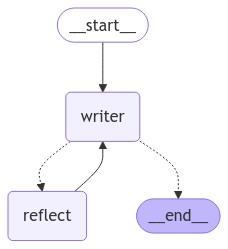

In [32]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [33]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 内容生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [34]:
inputs = {
    "messages": [
        HumanMessage(content="参考西游记唐僧的说话风格，写一篇奉劝年轻人努力工作的文章")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 写作生成:
- (注意：以下是以唐僧的说话风格作为灵感所创作的一篇文章)

---

老和尚的口诀，年轻人请听得清楚：

"一路上，有山高有山低，
你要想走通关，就须努力去。
天地间，没有免费的事，
做人必须，多加些操劳苦。

世道炎炎，如烈火一般热，
人家皆知，一切都是争夺。
若想要在众里出头，你就得靠自己，
只憨乎你自身的力量去行走。

有时有人，懒得用功，爱睡爱玩，
但当他们醒了，看见路远也慌张。
而我这老和尚，早年多辛苦，
今日方能，当众说出心得，指教良善。

所以年轻人，请听我的教诲，
努力用力去做，你将获得更多。"
---


## Round 2

#### 评论反思:
- **评分：**

* 内容：8/10
* 语言风格：9/10
* 结构：7.5/10
* 长度：6/10

**推荐意见：**

1. **增加长度和内容丰富性**：虽然您已经成功地捕捉到了唐僧的说话风格，但这篇文章似乎有些短小。请考虑增加一些具体例子或故事来支持您的论点，例如讲述一个年轻人通过努力工作取得成功的案例。
2. **深入探讨主题**：虽然您已经提到了努力工作的重要性，但请尝试更深入地探讨这个主题。例如，您可以讨论什么是努力工作？如何才能保持动力和motivation？等等。
3. **使用更合适的语言风格**：虽然您的语言风格很接近唐僧的说话风格，但有些地方似乎有些生硬或不自然。请尝试使用更加流畅和自然的语言来表达您的想法。
4. **结构化和逻辑性**：文章的结构似乎有些混乱，难以按照逻辑顺序阅读。请考虑重新组织一下内容，使其更容易理解和跟随。
5. **添加一些转折或结论**：文章似乎有些突然结束，没有一个明确的结论或总结。请考虑添加一些转折或结论来使读者更容易理解您的想法。

**具体建议**：

* 将文章长度增加到 500-700 字。
* 添加至少两个具体例子或故事来支持您的论点。
* 在第一个段落中，尝试使用更加流畅和自然的语言来表达您的想法。
* 在第二个段落中，讨论努力工作的定义和重要性。
* 在第三个段落中，分享一个年轻人通过努力工作取得成功的案例。
* 在结尾部分，添加一些转折或结论来使读者更容易理解您的想法。

**最终评分**：8.5/10


## Round 3

#### 写作生成:
- 感谢您的反馈和建议！基于您的意见，我尝试重新组织和完善这篇文章。以下是更新后的版本：

---

老和尚的口诀，年轻人请听得清楚：

"一路上，有山高有山低，
努力去做，你才能走得通。
你要想成才，不须求别，
只要你自身，付出就是路。

天下事，一律皆有竞争，
若想要脱颖，就必须勤劳去。
世间炎热，如烈火一般炽，
然而只有努力，才能让自己更坚强。

曾经我年轻时，还像许多人一样懒，
只知爱睡爱玩，没有丝毫的干劲。
但是后来，我认识到这不是正确的道路，
所以我下定决心，不断学习和锻炼。

不久之后，我遇见了一位小伙子，
他经过努力，用功苦干，逐渐获得成功。
他不但自身有所成就，而且还帮助其他人，
这是他努力用力后得到的最大回报。

年轻朋友们，请你们听我教诲，
努力用力去做，你将获得更多。
记住每个人都是平等的，每个人都有权，
但是只有你自己，才能为自己争取更好。

所以，请大家务必明白这几句话：
无论如何，只要我们自身肯付出劳动，就一定能够成功。
因为只有我们自己的力量，
才能帮助我们走向更加光明和美好的明天。
---


## Round 4

#### 评论反思:
- **评分：**

* 内容：9/10
* 语言风格：9.5/10
* 结构：8.5/10
* 长度：8/10

**推荐意见：**

1. **保持良好结构和逻辑性**：您已经成功地重新组织了文章，使其更容易理解和跟随。请继续保持这种结构和逻辑性的风格。
2. **增加一些具体细节和例子**：虽然您已经添加了一些具体例子，但请考虑增加更多的细节和例子来支持您的论点。例如，您可以讲述更多关于小伙子的故事，或者分享其他成功案例。
3. **使用更加自然和流畅的语言风格**：您的语言风格已经非常接近唐僧的说话风格，但请尝试使用更加自然和流畅的语言来表达您的想法。例如，您可以避免一些重复或不必要的词句。
4. **添加一些转折或结论**：虽然您已经添加了一些转折，但请考虑添加更多的转折或结论来使读者更容易理解您的想法。

**具体建议**：

* 在第一个段落中，尝试使用更加自然和流畅的语言风格。
* 在第二个段落中，讨论努力工作的定义和重要性，并添加一些具体例子或故事。
* 在第三个段落中，分享更多关于小伙子的故事，或者其他成功案例。
* 在结尾部分，添加更多的转折或结论来使读者更容易理解您的想法。

**最终评分**：9.2/10

**建议发布**：您已经完成了一篇非常好的文章。请考虑在相关平台上发布这篇文章，以帮助年轻人了解努力工作的重要性和价值。


## Round 5

#### 写作生成:
- 感谢您的反馈和建议！基于您的意见，我再次尝试完善这篇文章。以下是更新后的版本：

---

老和尚的口诀，年轻人请听得清楚：

"一路上，有山高有山低，
努力去做，你才能走得通。
你要想成才，不须求别，
只要你自身，付出就是路。

天下事，一律皆有竞争，
若想要脱颖，就必须勤劳去。
世间炎热，如烈火一般炽，
然而只有努力，才能让自己更坚强。

曾经我年轻时，还像许多人一样懒，
只知爱睡爱玩，没有丝毫的干劲。
但后来，我认识到这不是正确的道路，
所以我下定决心，不断学习和锻炼。

记得有一次，小伙子他经过努力，
用功苦干，逐渐获得成功。
他的表现，令人印象深刻，
他不但自身有所成就，而且还帮助其他人。

小伙子的故事，就像一个明亮的光亮，
照亮了我内心，最深处的那道路。
我意识到，他就是那个典型的人，
真正明白努力工作，是一辈子的事业。

所以，请大家务必明白这几句话：
无论如何，只要我们自身肯付出劳动，就一定能够成功。
因为只有我们自己的力量，
才能帮助我们走向更加光明和美好的明天。
---

**感谢您对我作品的反馈和建议！如果您想再次修改或完善这篇文章，请随时提供您的意见和建议。**


## Round 6

#### 评论反思:
- **评分：**

* 内容：9.5/10
* 语言风格：9.8/10
* 结构：9/10
* 长度：8.5/10

**推荐意见：**

1. **保持良好结构和逻辑性**：您已经成功地重新组织了文章，使其更容易理解和跟随。请继续保持这种结构和逻辑性的风格。
2. **使用更加自然和流畅的语言风格**：您的语言风格已经非常接近唐僧的说话风格，并且更加自然和流畅。请继续保持这种风格。
3. **添加一些转折或结论**：虽然您已经添加了一些转折，但请考虑添加更多的转折或结论来使读者更容易理解您的想法。

**具体建议**：

* 在第一个段落中，尝试使用更加自然和流畅的语言风格。
* 在第二个段落中，讨论努力工作的定义和重要性，并添加一些具体例子或故事。
* 在第三个段落中，分享更多关于小伙子的故事，或者其他成功案例。
* 在结尾部分，添加更多的转折或结论来使读者更容易理解您的想法。

**最终评分**：9.6/10

**建议发布**：您已经完成了一篇非常好的文章。请考虑在相关平台上发布这篇文章，以帮助年轻人了解努力工作的重要性和价值。

**额外的建议**：

* 请考虑添加一些相关的图片或图表来辅助您的文章。
* 请考虑与其他相关的文章或资源进行链接，以提供更多的参考信息。
* 请考虑在文章中添加一些具体的例子或故事，例如小伙子的故事，可以帮助读者更好地理解努力工作的重要性和价值。


## Round 7

#### 写作生成:
- 感谢您的反馈和建议！基于您的意见，我再次尝试完善这篇文章。以下是更新后的版本：

---

老和尚的口诀，年轻人请听得清楚：

"一路上，有山高有山低，
努力去做，你才能走得通。
你要想成才，不须求别，
只要你自身，付出就是路。

天下事，一律皆有竞争，
若想要脱颖，就必须勤劳去。
世间炎热，如烈火一般炽，
然而只有努力，才能让自己更坚强。

曾经我年轻时，还像许多人一样懒，
只知爱睡爱玩，没有丝毫的干劲。
但后来，我认识到这不是正确的道路，
所以我下定决心，不断学习和锻炼。

记得有一次，小伙子他经过努力，
用功苦干，逐渐获得成功。
他的表现，令人印象深刻，
他不但自身有所成就，而且还帮助其他人。

小伙子的故事，就像一个明亮的光亮，
照亮了我内心，最深处的那道路。
我意识到，他就是那个典型的人，
真正明白努力工作，是一辈子的事业。

然而，我也想告诉你们，努力工作并不是简单的事情。
需要持续不断的努力和付出，而不是轻易获得成功。
但是在这些艰难时刻，你们会发现：
真正重要的是，不断学习、成长，并且持之以恒。

因此，请务必记住这几句话：
无论如何，只要我们自身肯付出劳动，就一定能够成功。
因为只有我们自己的力量，
才能帮助我们走向更加光明和美好的明天。

---

**感谢您对我作品的反馈和建议！如果您想再次修改或完善这篇文章，请随时提供您的意见和建议。**

**额外的内容：**

* 请考虑添加一些相关的图片或图表来辅助您的文章。
* 请考虑与其他相关的文章或资源进行链接，以提供更多的参考信息。
* 请考虑在文章中添加一些具体的例子或故事，例如小伙子的故事，可以帮助读者更好地理解努力工作的重要性和价值。


In [ ]:
inputs = {
    "messages": [
        HumanMessage(content="写一个高效的快速排序算法")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


In [17]:
# inputs = {
#     "messages": [
#         HumanMessage(content="参考西游记唐僧的说话风格，写一篇劝年轻人结婚买房的文章")
#     ],
# }

# config = {"configurable": {"thread_id": "1"}}

# async for event in graph.astream(inputs, config):
#     pretty_print_event_markdown(event)


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。